In [1]:
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/BayArea_GIS')

medium_duty_class = [3, 4, 5, 6] # ref: https://afdc.energy.gov/data/10380
heavy_duty_class = [7, 8]

plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [6]:
tx_registration_data = read_csv('registration/TEXAS_MDHDbybiz.csv')
tx_registration_data.loc[:, 'MDV'] = tx_registration_data.loc[:, 'totcount'] * (tx_registration_data.loc[:, 'vin_gvw'].isin(medium_duty_class)) + \
0 * (tx_registration_data.loc[:, 'vin_gvw'].isin(heavy_duty_class))
tx_registration_data.loc[:, 'HDV'] = 0 * (tx_registration_data.loc[:, 'vin_gvw'].isin(medium_duty_class)) + \
tx_registration_data.loc[:, 'totcount'] * (tx_registration_data.loc[:, 'vin_gvw'].isin(heavy_duty_class))
print(tx_registration_data.totcount.sum())
tx_registration_data.head(5)

623668


,Unnamed: 0,zip_code,vocation,carrier_type,business_name,fuel,vin_gvw,vehicle_type,yr_mdl,totcount,MDV,HDV
0,1,73301,INDIVIDUAL,INDIVIDUAL,31556.0,DIESEL,8,TRACTOR TRUCK,1994,1,0,1
1,2,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,4,PICKUP,2008,1,1,0
2,3,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,6,STRAIGHT TRUCK,2005,1,1,0
3,4,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,7,STRAIGHT TRUCK,1990,1,0,1
4,5,75001,AGRICULTURE/FARM,PRIVATE,20583.0,DIESEL,7,TRACTOR TRUCK,1989,1,0,1


In [4]:
count_by_carrier_type = tx_registration_data.groupby(['carrier_type'])[['totcount']].sum()
count_by_carrier_type = count_by_carrier_type.reset_index()
count_by_carrier_type.loc[:, 'percentage'] = count_by_carrier_type.loc[:, 'totcount'] / \
count_by_carrier_type.loc[:, 'totcount'].sum() *100
print(count_by_carrier_type)

count_by_fuel_type = tx_registration_data.groupby(['fuel'])[['totcount']].sum()
count_by_fuel_type = count_by_fuel_type.reset_index()
count_by_fuel_type.loc[:, 'percentage'] = count_by_fuel_type.loc[:, 'totcount'] / \
count_by_fuel_type.loc[:, 'totcount'].sum() *100
print(count_by_fuel_type)

                    carrier_type  totcount  percentage
0                         DEALER      3977    0.637679
1                  FINANCE LEASE     13072    2.095987
2                       FOR HIRE     57753    9.260215
3             FULL SERVICE LEASE     42385    6.796084
4                     INDIVIDUAL    189452   30.377060
5   LOCAL GOVERNMENT (U.S. ONLY)     63897   10.245355
6   MANUFACTURER SPONSORED LEASE      7596    1.217956
7                        PRIVATE    227694   36.508848
8   STATE GOVERNMENT (U.S. ONLY)      5187    0.831693
9                U.S. GOVERNMENT       944    0.151363
10      UTILITIES/COMMUNICATIONS     11513    1.846014
11          VEHICLE MANUFACTURER       198    0.031748
                     fuel  totcount  percentage
0  COMPRESSED NATURAL GAS      1399    0.224318
1             CONVERTIBLE       128    0.020524
2                  DIESEL    544865   87.364591
3                FLEXIBLE       748    0.119936
4                     GAS     66997   10.7424

total tx private carriers  135562
total private trucks  227694
max private trucks in a firm 3340
avg. private trucks in a firm 4.619945216597342


Text(0.5, 1.0, 'private truck count distribution')

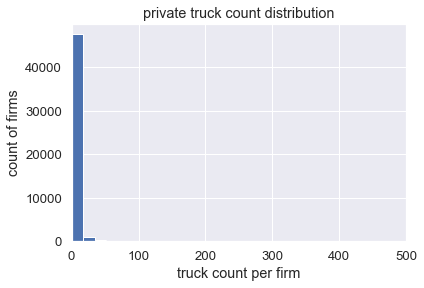

In [8]:
# private truck analysis
private_carriers = tx_registration_data.loc[tx_registration_data['carrier_type'] == 'PRIVATE']
private_truck_by_firm = private_carriers.groupby(['business_name'])[['totcount', 'MDV', 'HDV']].sum()
private_truck_by_firm = private_truck_by_firm.reset_index()
print('total tx private carriers ', len(private_carriers))
print('total private trucks ', private_carriers['totcount'].sum())
print('max private trucks in a firm', private_truck_by_firm['totcount'].max())
print('avg. private trucks in a firm', private_truck_by_firm['totcount'].mean())

private_truck_by_firm['totcount'].hist(bins = 200)
plt.xlim([0, 500])
plt.xlabel('truck count per firm')
plt.ylabel('count of firms')
plt.title('private truck count distribution')

In [11]:
size_interval = [-1, 2, 5, 10, 50, 100, 1000, private_truck_by_firm['totcount'].max()]
interval_name = ['0-2', '3-5', '6-10', '11-50', '51-100', '101-1000', '>1000']    
private_truck_by_firm.loc[:, 'size_group'] = pd.cut(private_truck_by_firm['totcount'], 
                                                bins = size_interval, right = True, 
                                                labels = interval_name)
# private_truck_by_firm.head(5)
truck_count_by_size = private_truck_by_firm.groupby('size_group').agg({'business_name': 'count',
                                                                   'totcount': ['sum','std'],
                                                                   'MDV': 'sum',
                                                                   'HDV': 'sum'})
truck_count_by_size = truck_count_by_size.reset_index()
truck_count_by_size.columns = ['fleet_size', 'total_carriers', 'total_trucks', 'total_truck_std',
                               'total_single_trucks', 'total_combination_trucks']
print(truck_count_by_size.head(5))


  fleet_size  total_carriers  total_trucks  total_truck_std  \
0        0-2           35332         42851         0.409300   
1        3-5            7524         27814         0.778540   
2       6-10            3287         24634         1.372236   
3      11-50            2711         54918         9.423459   
4     51-100             242         16781        13.560152   

   total_single_trucks  total_combination_trucks  
0                23120                     19731  
1                11554                     16260  
2                 8846                     15788  
3                16251                     38667  
4                 3301                     13480  


In [13]:
min_size_lookup = {'0-2':1, '3-5':3, '6-10':6, 
                   '11-50':11, '51-100':51, '101-1000':101, 
                   '>1000':1001}
truck_count_by_size.loc[:, 'min_size'] = truck_count_by_size.loc[:, 'fleet_size'].map(min_size_lookup)
truck_count_by_size.loc[:, 'avg_truck_per_carrier'] = truck_count_by_size.loc[:, 'total_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_sut_per_carrier'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_ct_per_carrier'] = truck_count_by_size.loc[:, 'total_combination_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'fraction_of_carrier'] = truck_count_by_size.loc[:, 'total_carriers'] / truck_count_by_size.loc[:, 'total_carriers'].sum()
truck_count_by_size.loc[:, 'percent_sut'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_trucks']
truck_count_by_size.to_csv('registration/private_fleet_size_distribution.csv', index = False, sep = ',')

total tx for-hire carriers  27108
total for-hire trucks  57753
max for-hire trucks in a firm 1400
avg. for-hire trucks in a firm 5.535077630822312


Text(0.5, 1.0, 'for-hire truck count distribution')

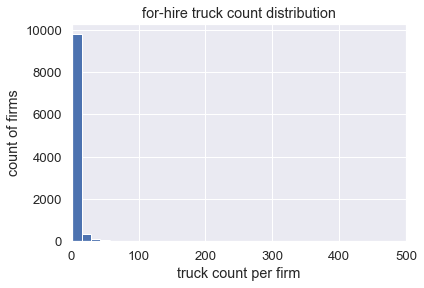

In [14]:
# for-hire truck analysis
for_hire_carriers = tx_registration_data.loc[tx_registration_data['carrier_type'] == 'FOR HIRE']
print('total tx for-hire carriers ', len(for_hire_carriers))

for_hire_truck_by_firm = for_hire_carriers.groupby(['business_name'])[['totcount', 'MDV', 'HDV']].sum()
for_hire_truck_by_firm = for_hire_truck_by_firm.reset_index()
print('total for-hire trucks ', for_hire_truck_by_firm['totcount'].sum())
print('max for-hire trucks in a firm', for_hire_truck_by_firm['totcount'].max())
print('avg. for-hire trucks in a firm', for_hire_truck_by_firm['totcount'].mean())

for_hire_truck_by_firm['totcount'].hist(bins = 100)
plt.xlim([0, 500])
plt.xlabel('truck count per firm')
plt.ylabel('count of firms')
plt.title('for-hire truck count distribution')

In [15]:
size_interval = [-1, 2, 5, 10, 50, 100, 1000, for_hire_truck_by_firm['totcount'].max()]
interval_name = ['0-2', '3-5', '6-10', '11-50', '51-100', '101-1000', '>1000']    
for_hire_truck_by_firm.loc[:, 'size_group'] = pd.cut(for_hire_truck_by_firm['totcount'], 
                                                bins = size_interval, right = True, 
                                                labels = interval_name)
# private_truck_by_firm.head(5)
truck_count_by_size = for_hire_truck_by_firm.groupby('size_group').agg({'business_name': 'count',
                                                                   'totcount': ['sum','std'],
                                                                   'MDV': 'sum',
                                                                   'HDV': 'sum'})
truck_count_by_size = truck_count_by_size.reset_index()
truck_count_by_size.columns = ['fleet_size', 'total_carriers', 'total_trucks', 'total_truck_std',
                               'total_single_trucks', 'total_combination_trucks']
print(truck_count_by_size.head(5))


  fleet_size  total_carriers  total_trucks  total_truck_std  \
0        0-2            7033          8679         0.423427   
1        3-5            1724          6390         0.784901   
2       6-10             812          6066         1.364645   
3      11-50             729         15041         9.111751   
4     51-100              76          5209        15.282618   

   total_single_trucks  total_combination_trucks  
0                 1435                      7244  
1                  941                      5449  
2                  884                      5182  
3                 1631                     13410  
4                  364                      4845  


In [16]:
min_size_lookup = {'0-2':1, '3-5':3, '6-10':6, 
                   '11-50':11, '51-100':51, '101-1000':101, 
                   '>1000':1001}
truck_count_by_size.loc[:, 'min_size'] = truck_count_by_size.loc[:, 'fleet_size'].map(min_size_lookup)
truck_count_by_size.loc[:, 'avg_truck_per_carrier'] = truck_count_by_size.loc[:, 'total_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_sut_per_carrier'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_ct_per_carrier'] = truck_count_by_size.loc[:, 'total_combination_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'fraction_of_carrier'] = truck_count_by_size.loc[:, 'total_carriers'] / truck_count_by_size.loc[:, 'total_carriers'].sum()
truck_count_by_size.loc[:, 'percent_sut'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_trucks']
truck_count_by_size.to_csv('registration/for_hire_fleet_size_distribution.csv', index = False, sep = ',')

total tx for-hire carriers  17529
total for-hire trucks  63053
max for-hire trucks in a firm 7033
avg. for-hire trucks in a firm 19.679463171036204


Text(0.5, 1.0, 'for-hire truck count distribution')

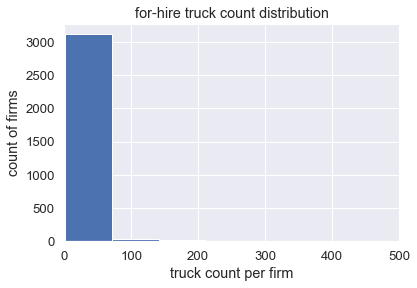

In [17]:
# for-leasing truck analysis
for_lease_carriers = tx_registration_data.loc[tx_registration_data['carrier_type'].isin(['FINANCE LEASE', \
                                                                                        'FULL SERVICE LEASE', \
                                                                                        'MANUFACTURER SPONSORED LEASE'])]
print('total tx for-hire carriers ', len(for_lease_carriers))

for_lease_truck_by_firm = for_lease_carriers.groupby(['business_name'])[['totcount', 'MDV', 'HDV']].sum()
for_lease_truck_by_firm = for_lease_truck_by_firm.reset_index()
print('total for-hire trucks ', for_lease_truck_by_firm['totcount'].sum())
print('max for-hire trucks in a firm', for_lease_truck_by_firm['totcount'].max())
print('avg. for-hire trucks in a firm', for_lease_truck_by_firm['totcount'].mean())

for_lease_truck_by_firm['totcount'].hist(bins = 100)
plt.xlim([0, 500])
plt.xlabel('truck count per firm')
plt.ylabel('count of firms')
plt.title('for-hire truck count distribution')

In [18]:
size_interval = [-1, 2, 5, 10, 50, 100, 1000, for_lease_truck_by_firm['totcount'].max()]
interval_name = ['0-2', '3-5', '6-10', '11-50', '51-100', '101-1000', '>1000']    
for_lease_truck_by_firm.loc[:, 'size_group'] = pd.cut(for_lease_truck_by_firm['totcount'], 
                                                bins = size_interval, right = True, 
                                                labels = interval_name)
# private_truck_by_firm.head(5)
truck_count_by_size = for_lease_truck_by_firm.groupby('size_group').agg({'business_name': 'count',
                                                                   'totcount': ['sum','std'],
                                                                   'MDV': 'sum',
                                                                   'HDV': 'sum'})
truck_count_by_size = truck_count_by_size.reset_index()
truck_count_by_size.columns = ['fleet_size', 'total_carriers', 'total_trucks', 'total_truck_std',
                               'total_single_trucks', 'total_combination_trucks']
print(truck_count_by_size.head(5))

  fleet_size  total_carriers  total_trucks  total_truck_std  \
0        0-2            2185          2574         0.382627   
1        3-5             380          1413         0.797210   
2       6-10             233          1758         1.401626   
3      11-50             282          6157         9.940601   
4     51-100              50          3373        13.739872   

   total_single_trucks  total_combination_trucks  
0                 1220                      1354  
1                  474                       939  
2                  555                      1203  
3                 1442                      4715  
4                  771                      2602  


In [19]:
min_size_lookup = {'0-2':1, '3-5':3, '6-10':6, 
                   '11-50':11, '51-100':51, '101-1000':101, 
                   '>1000':1001}
truck_count_by_size.loc[:, 'min_size'] = truck_count_by_size.loc[:, 'fleet_size'].map(min_size_lookup)
truck_count_by_size.loc[:, 'avg_truck_per_carrier'] = truck_count_by_size.loc[:, 'total_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_sut_per_carrier'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'avg_ct_per_carrier'] = truck_count_by_size.loc[:, 'total_combination_trucks'] / truck_count_by_size.loc[:, 'total_carriers']
truck_count_by_size.loc[:, 'fraction_of_carrier'] = truck_count_by_size.loc[:, 'total_carriers'] / truck_count_by_size.loc[:, 'total_carriers'].sum()
truck_count_by_size.loc[:, 'percent_sut'] = truck_count_by_size.loc[:, 'total_single_trucks'] / truck_count_by_size.loc[:, 'total_trucks']
truck_count_by_size.to_csv('registration/for_lease_fleet_size_distribution.csv', index = False, sep = ',')

In [1]:
pip install tensorflow

     |████████████████████████████████| 217.4 MB 1.0 MB/s eta 0:00:012     |████████████████████████████▍   | 193.2 MB 11.1 MB/s eta 0:00:03
     |████████████████████████████████| 13.2 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 5.8 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 6.0 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 962 kB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 5.2 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB